# RAPIDS & Scanpy Single-Cell RNA Workflow

This notebook demonstrates an end-to-end single-cell RNA workflow that begins with preprocessing a gene x cell count matrix and results in a visualization of the clustered cells for further analysis. 

In [1]:
# Import requirements
import numpy as np
import scanpy as sc
import sys
import os

import cupy as cp

In [2]:
# Inputs
in_file = "/home/cjnolet/covid_omics_local/Counts_lung_cells.csv"
out_dir = "."

In [3]:
import cudf
import anndata

import time
start = time.time()

## Preprocessing Stage 1
### (load counts -> filter -> normalize)

In [4]:
%%time
# Load data
adata = cudf.read_csv(in_file)

CPU times: user 3.67 s, sys: 2.19 s, total: 5.86 s
Wall time: 5.93 s


In [5]:
adata.shape

(32738, 39779)

In [6]:
%%time
cell_name = adata["cell_name"]
mito_genes = cell_name.str.startswith("MT-")
adata = adata.set_index("cell_name")

CPU times: user 362 ms, sys: 5.22 ms, total: 367 ms
Wall time: 366 ms


In [7]:
%%time
gpu_matrix = adata.as_gpu_matrix()

CPU times: user 2.69 s, sys: 149 ms, total: 2.84 s
Wall time: 2.84 s


In [8]:
%%time
import cupy as cp
gpu_array = cp.asarray(gpu_matrix, dtype=cp.float32)

CPU times: user 4.51 ms, sys: 2.3 ms, total: 6.81 ms
Wall time: 5.81 ms


In [9]:
%%time
sparse_gpu_array = cp.sparse.csr_matrix(gpu_array, dtype=cp.float32).T

CPU times: user 525 ms, sys: 343 ms, total: 868 ms
Wall time: 872 ms


In [10]:
del adata
del gpu_matrix

In [11]:
%%time
# Filter cells w/ 200 <= n_genes <= 6000
col_sums = sparse_gpu_array.sum(axis=1)
query = ((200 <= col_sums) & (col_sums <= 6000)).ravel()
filtered_cells = sparse_gpu_array.get()[query.get()]

CPU times: user 1.64 s, sys: 1.53 s, total: 3.17 s
Wall time: 3.17 s


In [12]:
%%time
## Filter cells with >15% MT reads
n_counts = filtered_cells.sum(axis=1)
percent_mito = (filtered_cells[:,mito_genes.to_array()].sum(axis=1) / n_counts).ravel()
filtered_cells = filtered_cells[np.asarray(percent_mito < 0.15).ravel(),:]

CPU times: user 394 ms, sys: 142 ms, total: 536 ms
Wall time: 534 ms


In [13]:
%%time
## Remove zero columns
thr = np.asarray(filtered_cells.sum(axis=0) > 1).ravel()
filtered_cells = filtered_cells[:,thr]
filtered_cells = cp.array(filtered_cells.todense())

CPU times: user 481 ms, sys: 2.33 s, total: 2.81 s
Wall time: 2.83 s


In [14]:
filtered_cells

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
%%time
## Normlaize to sum to 1e4 and log norm
target_sum = 1e4
sums = cp.array(target_sum / filtered_cells.sum(axis=1)).ravel()
normalized = cp.array(filtered_cells) * sums[:, None]

CPU times: user 135 ms, sys: 108 ms, total: 244 ms
Wall time: 245 ms


In [16]:
normalized.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True

In [17]:
%%time
normalized = cp.log1p(normalized)

CPU times: user 11.2 ms, sys: 14.6 ms, total: 25.8 ms
Wall time: 29.1 ms


## Preprocess Stage 2
### (regress -> scale -> PCA) 

In [18]:
# scanpy uses a Gaussian GLM w/ identity link, which is equivalent to Linear Regression w/  OLS.

In [19]:
n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

In [20]:
regressors = cp.ones((n_counts.shape[0]*3)).reshape((n_counts.shape[0], 3), order="F")

In [21]:
regressors[:, 1] = n_counts
regressors[:, 2] = percent_mito

In [22]:
df_regressors = cudf.DataFrame.from_gpu_matrix(regressors)

In [23]:
# For each gene, we want to subtract the predicted values from the original values to
# regress out effects of total counts per cell and the percentage expressed of mitochondrial genes 

In [24]:
from cuml.linear_model import LinearRegression

def _regress_out_chunk(data_chunk, regressors):
    
    for col in range(data_chunk.shape[1]):
        y = data_chunk[:,col]
        X = regressors
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X, y, convert_dtype=True)
        mu = lr.predict(X)
        data_chunk[:,col] = data_chunk[:,col] - mu
        
    return data_chunk

In [25]:
%%time
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

import dask.array as da

cluster = LocalCUDACluster()
client = Client(cluster)

bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


CPU times: user 432 ms, sys: 233 ms, total: 665 ms
Wall time: 1.99 s


In [26]:
client

Client Scheduler: tcp://127.0.0.1:40598 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


In [27]:
%%time
normalized = cp.asfortranarray(normalized)

da_normalized = da.from_array(normalized, chunks=(-1, 1000))
da_normalized = da_normalized.map_blocks(lambda cols: _regress_out_chunk(cols, df_regressors), dtype=cp.float32)

CPU times: user 320 ms, sys: 129 ms, total: 450 ms
Wall time: 442 ms


In [28]:
da_normalized

dask.array<lambda, shape=(34808, 27292), dtype=float32, chunksize=(34808, 1000), chunktype=cupy.ndarray>

In [29]:
%%time
normalized = da_normalized.compute()

CPU times: user 6.83 s, sys: 14.3 s, total: 21.1 s
Wall time: 2min 12s


In [30]:
client.close()
cluster.close()

In [31]:
normalized.shape

(34808, 27292)

In [32]:
# Scale to unit variance and clip values w/ std_dev > 10
mean = normalized.mean(axis=0)
stddev = cp.sqrt(normalized.var(axis=0))


In [33]:
normalized -= mean

In [34]:
normalized /= stddev

In [35]:
normalized

array([[-0.01200257, -0.08035412, -0.1492246 , ..., -0.37772614,
        -0.02721023, -0.01434372],
       [-0.01673374, -0.08006922, -0.1558096 , ..., -0.3878863 ,
        -0.03946271, -0.00719945],
       [-0.00961005, -0.07853848, -0.15187058, ..., -0.3571359 ,
        -0.02105244, -0.01454915],
       ...,
       [-0.00848477, -0.07449298, -0.16284741, ..., -0.32228634,
        -0.01821844, -0.0090966 ],
       [-0.01404243, -0.08206916, -0.14645931, ..., -0.3965983 ,
        -0.03245712, -0.01445896],
       [-0.00932747, -0.07660332, -0.15743028, ..., -0.3411361 ,
        -0.02035867, -0.01158159]], dtype=float32)

In [36]:
normalized[normalized>10] = 10

In [37]:
normalized = cp.asfortranarray(normalized)

## Cluster & Visualize
### (pca -> cluster -> visualize)

In [38]:
%%time
import anndata

adata = anndata.AnnData(normalized.get())

CPU times: user 516 ms, sys: 834 ms, total: 1.35 s
Wall time: 1.34 s


In [39]:
%%time
# PCA
sc.tl.pca(adata, n_comps=50)

CPU times: user 18min 41s, sys: 5min 33s, total: 24min 15s
Wall time: 52.8 s


In [40]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_pcs=50, method='rapids')\

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


CPU times: user 3.89 s, sys: 490 ms, total: 4.39 s
Wall time: 4.22 s


In [41]:
%%time
# UMAP
sc.tl.umap(adata, method='rapids')

AscontiguousArrayTime: 0.0036308765411376953
UMAP TIME: 0.6883175373077393
CPU times: user 388 ms, sys: 313 ms, total: 701 ms
Wall time: 700 ms


In [42]:
%%time
# Louvain clustering
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 205 ms, sys: 53.9 ms, total: 259 ms
Wall time: 260 ms


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cugraph/structure/graph.py:334: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


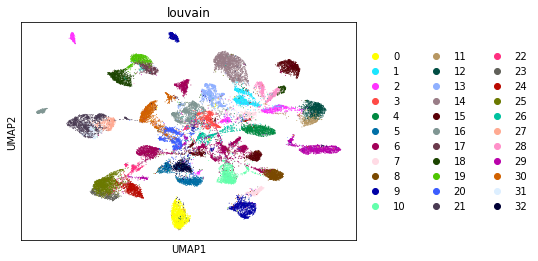

CPU times: user 525 ms, sys: 199 ms, total: 724 ms
Wall time: 519 ms


In [43]:
%%time
# Plot
sc.pl.umap(adata, color='louvain')

In [44]:
time.time() - start

217.8822205066681